# The deep painting app - data preprocessing

In [315]:

from tensorflow_datasets import as_dataframe

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

In [316]:
from tensorflow.keras.preprocessing import image_dataset_from_directory 
import os


def charge_and_divide_dataset(path="", validation_split=0.2, batch_size=1, img_height = 180, img_width = 180):
    """
    Charge the dataset from the specified path (by default: current path)
    The database must be divided into folders (one folder per class).
    Return a tuple od two datasets:
    * dataset_train
    * dataset_validation 
    -> both are type: tensorflow.python.data.ops.dataset_ops.BatchDataset
    batch_size is the number of element per batch. By default: 1
    image size: img_height and img_width. By default 180 for both
    validation_split: fraction of data to reserve for validation. Bydefault 0.2
    """
    
    # raise an error if batch_size is not a positive interger
    if not type(batch_size) is int or batch_size < 0:
        raise TypeError("batch_size must be a positive integer") 

    # raise an error if path is not a string
    if not type(path) is str:
        raise TypeError("path must be a string") 
        
    # raise an error if validation_split is not not a float between 0 and 1
    if not type(validation_split) is float or validation_split > 1 or validation_split < 0:
        raise TypeError("validation_split must be a float between 0 and 1")
    
    #raise an error if img_height is not a positive int
    if not type(img_height) is int or img_height <= 0:
        raise TypeError("img_height must be a positive integer")

    #raise an error if img_width is not a positive int
    if not type(img_width) is int or img_width <= 0:
        raise TypeError("img_width must be a positive integer")    
    
    dataset_train = image_dataset_from_directory(
        path, 
        validation_split = validation_split,
        labels='inferred',
        subset='training',
        label_mode='categorical',
        shuffle = True,
        seed = 0,
        image_size = (img_height, img_width),
        color_mode='rgb',
        batch_size=batch_size)
    
    dataset_validation = image_dataset_from_directory(
        path, 
        validation_split = validation_split,
        labels='inferred',
        subset='validation',
        label_mode='categorical',
        shuffle = True,
        seed = 1,
        image_size = (img_height, img_width),
        color_mode='rgb',
        batch_size=batch_size)
    
    return dataset_train, dataset_validation

In [318]:
#test

train_ds, test_ds = charge_and_divide_dataset(
    path="../raw_data/Portrait_Painting_Dataset_For_Different_Movements/orgImg",
    img_height=180,
    img_width=180,
    batch_size=1,
    validation_split=0.2)

Found 923 files belonging to 6 classes.
Using 739 files for training.
Found 923 files belonging to 6 classes.
Using 184 files for validation.


In [319]:
def classes_names_to_dict(dataset):
    """
    return a dict of the classes and corresponding vectors
    dataset type: tensorflow.python.data.ops.dataset_ops.BatchDataset
    https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset
    """
    
    # raise an error if dataset is not a tensorflow BatchDataset
    if not dataset.__class__.__name__ == 'BatchDataset':
        raise TypeError("This function has been written for tensorflow BatchDataset\n\
           Please check https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset") 
    
    classes_names = dataset.class_names
    identity_matrix = np.identity(len(classes_names)).tolist()
    
    classes_dict = dict(zip(classes_names, identity_matrix))
    return classes_dict

In [320]:
def give_class_name(vector, class_names_dict):
    """
    return the artistic movement given the associated vector in class_names_dict
    vector can be a list ou a np.array
    class_names_dict should be set with the classes_names_to_dict from this file librairy
    """
    for class_name, v in class_names_dict.items():
        if v == list(vector):
            return class_name

In [321]:
#test

class_names_dict = classes_names_to_dict(test_ds)
class_names_dict

{'NorthernRenaiss': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Ukiyo': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'highRenaiss': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'impress': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'postImpress': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'rococo': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

In [322]:
#test

print(give_class_name(np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0]), class_names_dict))

print(give_class_name([0.0, 0.0, 0.0, 0.0, 1.0, 0.0], class_names_dict))

highRenaiss
postImpress


In [507]:
import math

def display_paintings_and_classes(dataset, n=1):
    """
    display n paintings and classes from dataset, in a optimzed square grid
    images must be RGB, floats between 0 and 255
    dataset type: tensorflow.python.data.ops.dataset_ops.BatchDataset
    """
 
    # total number of paintings
    n_max = dataset.cardinality().numpy()
    
    # raise an error if dataset is not a tensorflow BatchDataset
    if not dataset.__class__.__name__ == 'BatchDataset':
        raise TypeError("This function has been written for tensorflow BatchDataset\n\
           Please check https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset") 
        
    # raise an error if n is not a positive interger
    if not type(n) is int or n <= 0:
        raise TypeError("n must be a positive integer") 
    
    # raise an error if n > max number of paintings
    if n > n_max:
        raise TypeError("n must be less than or equal to the total number of paintings") 
    
    # display paintings
    n_by_row = math.isqrt(n)
    n_rows = math.ceil(n / n_by_row)
    class_names_dict = classes_names_to_dict(dataset)
    figure, axs = plt.subplots(n_rows, n_by_row, figsize=(20,20))
    i=0
    for x, y in dataset.as_numpy_iterator():    
        axs[i//n_by_row, i%n_by_row].imshow(x[0]/255)
        axs[i//n_by_row, i%n_by_row].set_title(give_class_name(y[0], class_names_dict))
        axs[i//n_by_row, i%n_by_row].axis('scaled')
        i += 1
        if i > n - 1:
            break
    # remove unused subplots on the last row
    while i < n_rows * n_by_row:
        axs[i//n_by_row, i%n_by_row].set_axis_off()
        i += 1
    figure.tight_layout()
    plt.show()

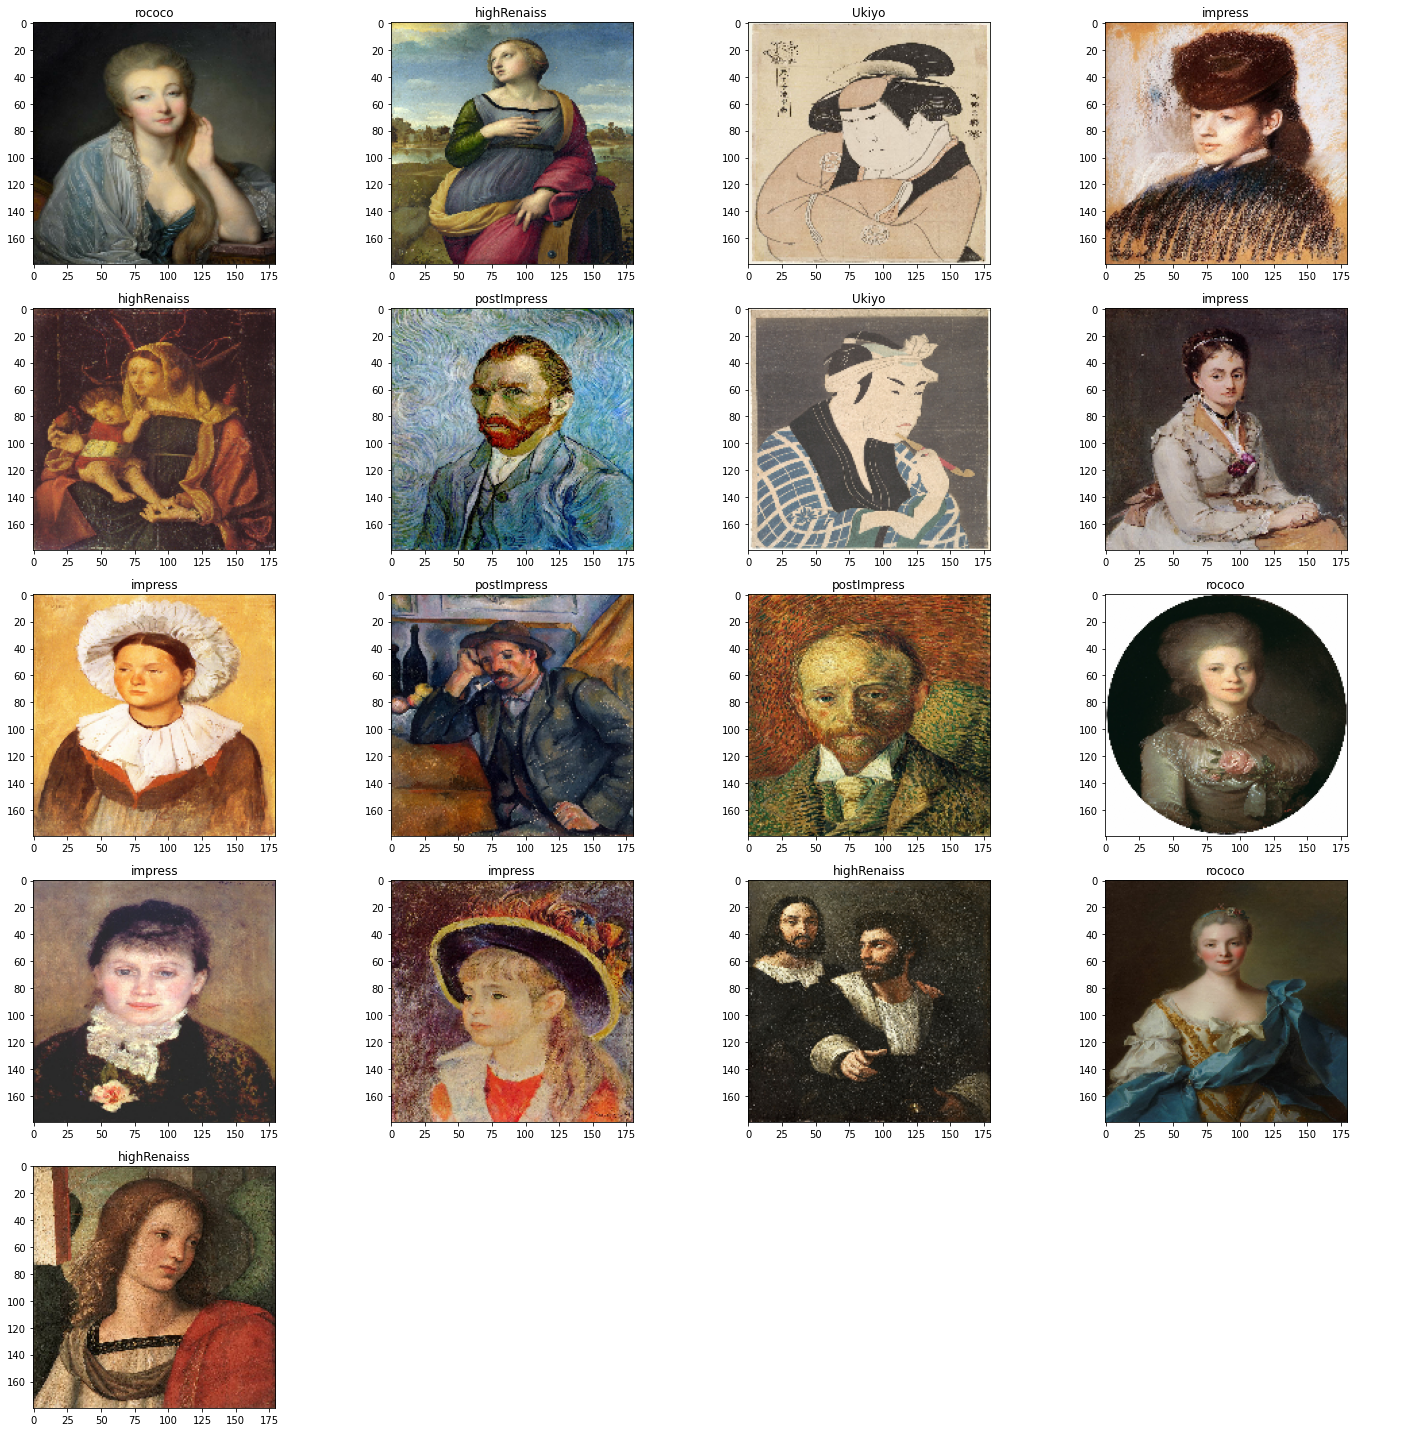

In [514]:
#test
display_paintings_and_classes(test_ds, n=17)

In [517]:
# previous version:

#figure, axs = plt.subplots(20, 5, figsize=(20,100))
#for x_batch, y_batch in dataset.take(1).as_numpy_iterator():
#    for img, y_label, ax in zip(x_batch, y_batch, axs.flat):
#        ax.imshow(img/255)
#        ax.set_title(y_label)
#plt.show()
